In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import ml_lit_anal as ml
import re
import nltk
import pickle
import operator
import google_scholar_parser as gs
import pandas as pd
import networkx as nx
import graph_tool.all as gt
import itertools
import matplotlib.pyplot as plt
import numpy as np
import collections
import IPython.display
import seaborn
import ggplot
import math

## A generative model of the machine learning literature

"Let's build a generative model of the machine learning literature" Andrew Ng, lecture on GDA and Naive Bayes

The idea of this analysis is to show how machine learning relates to various scientific and technical fields. In its treatment of the literature, it draws both on citation analysis techniques developed  in various fields, as well as text mining, social netowrk analysis and indeed machine learning itself to explore this rather large literature. 

### Loading the literature and cleaning the topics

I downloaded from Thomson ISI Web of Science all the references returned by the query 'machine learning.' I also downloaded the cited references. 

Other possible queries such as 'data mining' return too many references to handle -- over 2 million, so I stuck with machine learning, which return aroudn 25,000 references.




In [3]:
df = ml.load_records('data/machine_learning_WOS/')
print('There are %s records in the dataset'%df.shape[0])

#clean topics
df = ml.clean_topics(df)
df = ml.clean_fields(df)

There are 28619 records in the dataset


In [4]:
print('%s topic fields are null'%sum(df.topics.isnull()))
print('%s abstract fields are null'%sum(df.AB.isnull()))
print('%s keywords Plus fields are null'%sum(df.ID.isnull()))
print('%s author fields are null'%sum(df.AF.isnull()))

9871 topic fields are null
1008 abstract fields are null
10692 keywords Plus fields are null
27 author fields are null


The publication years profile is typical in some ways but shows enormous growth from the late 1980s onwards. Was this around the time that artificial intelligence started to seem unpopular?

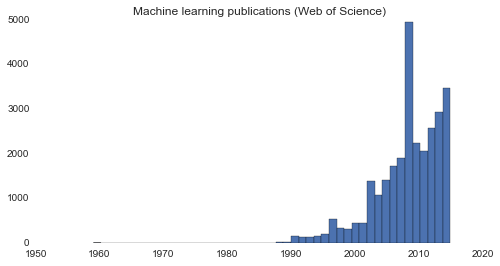

In [4]:
plt.figure(figsize=(8,4))
plt.title('Machine learning publications (Web of Science)')

df.PY.hist(bins=len(df.PY.unique()))
plt.box(on=False)

There are a lot of missing keywords (the WoS DE field). It should be possible to fill in some of the missing topic fields by using keywords from the abstracts. I'll attempt this a bit later. 

## Fields of research in the literature



In [5]:
#actually this is more about fields than topics

all_fields = sorted([e  for el in df.fields.dropna() for e in el])
fields_set = set(all_fields)
field_counts = {e:all_fields.count(e) for e in fields_set}

Many different fields of research or disciplines are included in the results, and they help make sense of the multi-disciplinary nature of machine learning techniques. 

In [7]:
print('%s different fields appear in the machine learning literature'%len(fields_set))
field_counts_s = sorted(field_counts.iteritems(), key=lambda(k,v):(-v,k))
field_counts_s[0:30]


139 different fields appear in the machine learning literature


[('computer science', 18810),
 ('engineering', 7818),
 ('biochemistry & molecular biology', 1950),
 ('mathematics', 1672),
 ('mathematical & computational biology', 1599),
 ('automation & control systems', 1402),
 ('imaging science & photographic technology', 1066),
 ('telecommunications', 1033),
 ('biotechnology & applied microbiology', 999),
 ('operations research & management science', 978),
 ('medical informatics', 832),
 ('neurosciences & neurology', 678),
 ('science & technology - other topics', 659),
 ('chemistry', 626),
 ('radiology, nuclear medicine & medical imaging', 594),
 ('robotics', 584),
 ('optics', 521),
 ('environmental sciences & ecology', 479),
 ('information science & library science', 433),
 ('remote sensing', 423),
 ('physics', 396),
 ('pharmacology & pharmacy', 354),
 ('acoustics', 312),
 ('genetics & heredity', 312),
 ('business & economics', 306),
 ('instruments & instrumentation', 287),
 ('biophysics', 253),
 ('materials science', 235),
 ('health care science

The literature does reach back into the 1950s, but the real growth is in the 1990s-2000s. From 2005 onwards, several thousand publications a year appear.

We can see also the distribution of fields. Computer science totally dominates the fields. That only goes to show perhaps that machine learning is a computer science-driven set of techniques. But other fields such as automation and control systems,  biochemistry/molecular biology, management science, robotics, telecommunications and imaging science are important components. This already shows something of the wide dissemination of machine learning techniques. 

(139, 139)


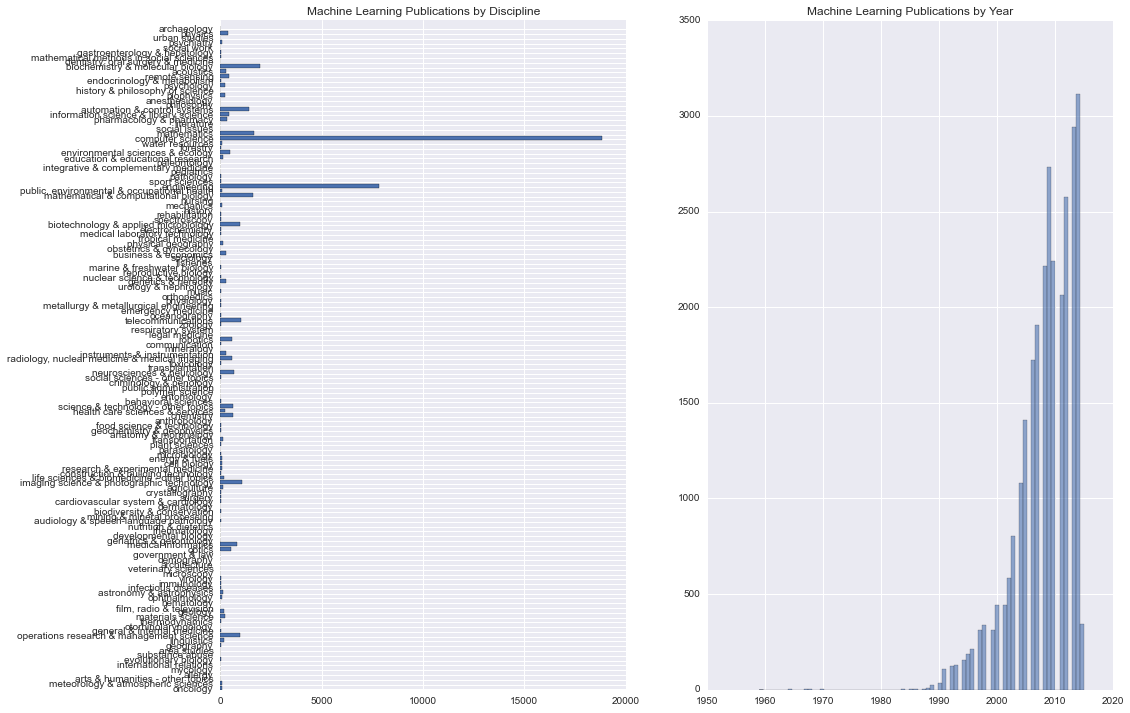

In [8]:
#the problem is that computer science clutters everything -- get rid of it?
figure = plt.figure(figsize=(16,12))
plt.subplot(122)

plt.hist(df.PY.dropna(), bins=80, alpha=0.6)
plt.title('Machine Learning Publications by Year')
plt.subplot(1,2,1)
#this doesn't work -- TBA
major_fields = {f:v for f,v in field_counts.iteritems() if v > 3 or f is not 'computer science'}
print(len(field_counts), len(major_fields))
heights = major_fields.values()
ind= np.arange(len(heights))
plt.barh(ind, heights)
width =0.2
plt.title('Machine Learning Publications by Discipline')
xticks = plt.yticks(ind+width/2., major_fields.keys() )

### Some network exploration could be useful for the relation between the disciplines

What disciplines connect the others up?

In [9]:
df = ml.clean_fields(df)
gr_f = nx.Graph()
gr_f.add_edges_from([i for de in df.fields.dropna() for i in itertools.combinations(de,2)])

In [10]:
f_g = gt.Graph(directed = False)
f_g.add_vertex(n=len(fields_set))
v_f = f_g.new_vertex_property('string')
field_list = list(fields_set)
# add fields as node properties
for v_i in range(0, f_g.num_vertices()):
    v_f[f_g.vertex(v_i)] = field_list[v_i]
f_g.vertex_properties['field'] = v_f

# add cofields as edges
#edges = [f_g.add_edge(field_list.index(s), field_list.index(t)) 
 #                     for de in df.fields.dropna() for s,t in itertools.combinations(de,2)]

e_w = f_g.new_edge_property('int')

for de in df.fields.dropna():
    for s,t in itertools.combinations(de,2):
        s_i = field_list.index(s)
        t_i = field_list.index(t)
        if f_g.edge(s_i,t_i) is not None:
            e = f_g.edge(s_i, t_i)
            e_w[e] +=1
        else:
            e = f_g.add_edge(s_i, t_i)
            e_w[e] = 0
f_g.edge_properties['cofield'] = e_w

In [11]:
print f_g.num_edges()
f_g.num_vertices()

877


139

In [12]:
v_comm = gt.community_structure(f_g, 1000, 5)
#v_comm = gt.betweenness(f_g)

In [18]:
import numpy
u = gt.GraphView(f_g, vfilt=gt.label_largest_component(f_g))
deg = u.degree_property_map('total', weight = f_g.edge_properties['cofield'])
deg.fa = 2*(numpy.sqrt(deg.fa)*0.5  + 0.4)
edg = f_g.edge_properties['cofield']
edg.fa = (numpy.sqrt(edg.fa)*0.6+1)
ebet = gt.betweenness(f_g)[1]

In [23]:
pos, int = gt.interactive_window(u, pos=gt.radial_tree_layout(f_g, f_g.vertex(1)),
                         vertex_size = deg, 
                         vertex_fill_color = v_comm, 
                         vertex_text = f_g.vertex_properties['field'],
                         vertex_text_position = 0.2,
                         vertex_font_size = 9,
                         vertex_font_family = 'sans serif',
                         edge_pen_width = edg,
                         edge_color=ebet,
                         output_size = (800,1200)
                         )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7ff40d25ebd0, at 0x7ff40ccce410>

In [22]:
gt.graph_draw(f_g, pos=pos, 
              vertex_size = deg, 
                        vertex_fill_color = v_comm, 
                        vertex_text = f_g.vertex_properties['field'],
                        vertex_text_position = 0.2,
                        vertex_font_size = 9,
                        vertex_font_family = 'sans serif',
                        edge_pen_width = edg,
                        output_size = (800,1200),
              output = 'ml_fields.png')

ValueError: operands could not be broadcast together with shapes (139,) (135,) 

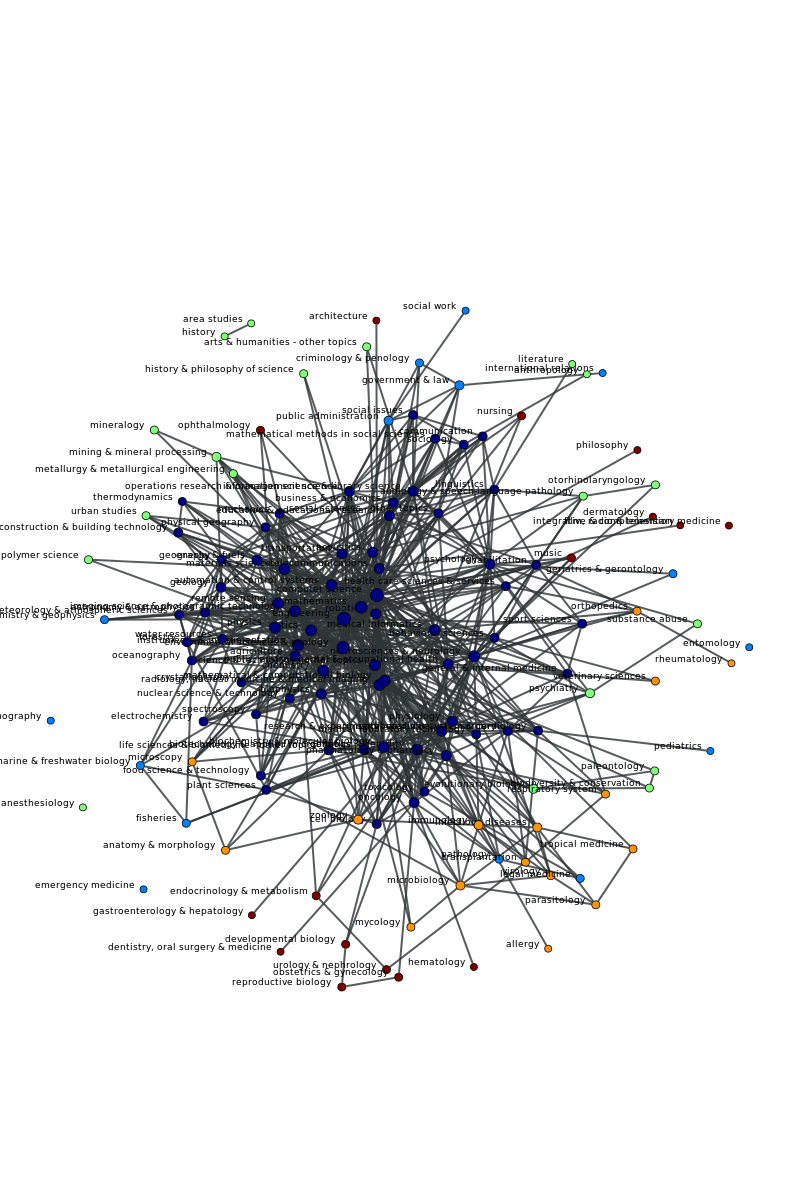

In [109]:
i = IPython.display.Image(filename='ml_fields.png')
i

65 nodes in graph
586 edges in graph


/usr/local/lib/python2.7/dist-packages/pygraphviz/agraph.py:1281: RuntimeWarning: Fontconfig warning: "/etc/fonts/conf.d/50-user.conf", line 9: reading configurations from ~/.fonts.conf is deprecated.

  warnings.warn("".join(errors),RuntimeWarning)


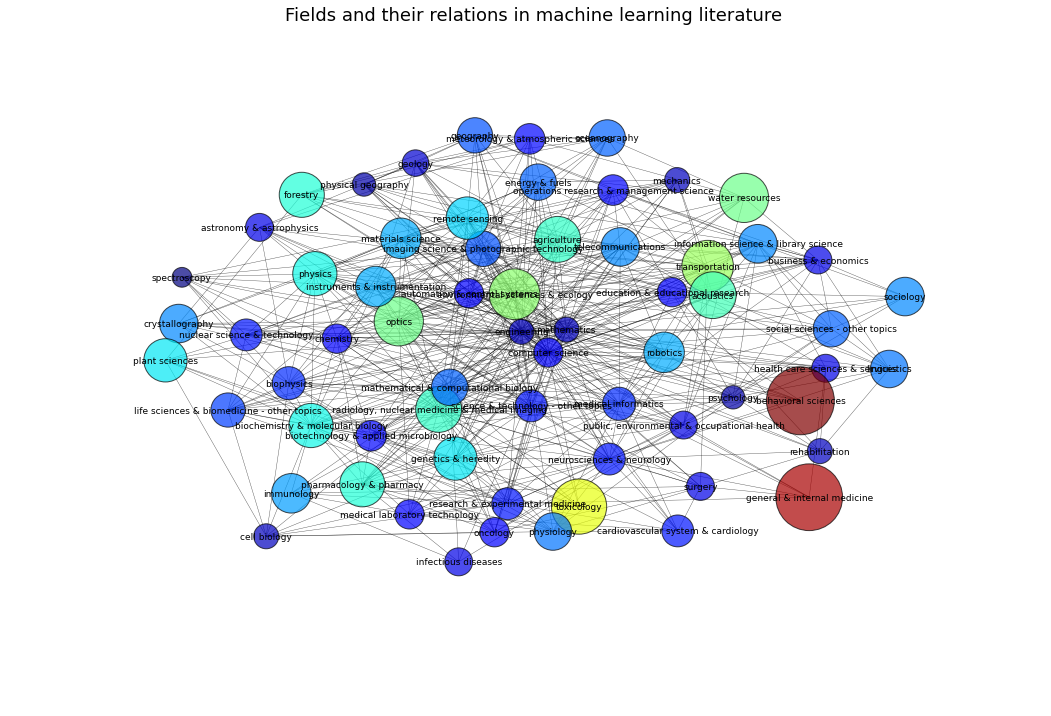

In [8]:
core = ml.trim_nodes(gr_f, 8)
#core = ml.trim_edges(core, 3)
len(core)

plt.figure(figsize=(18,12))
plt.title('Fields and their relations in machine learning literature', fontsize=18)
nx.draw_graphviz(core, width=0.4,
                 font_size=9,
                 alpha = 0.7,
                 node_size = [s*5000 for s in nx.degree_centrality(core).values()],
                 node_color = [s for s in nx.degree(core).values()])

In [10]:
degree_c = nx.degree_centrality(core)
degree_cs = ml.sorted_map(degree_c)
degree_cs

[('computer science', 0.921875),
 ('engineering', 0.890625),
 ('mathematics', 0.609375),
 ('environmental sciences & ecology', 0.53125),
 ('mathematical & computational biology', 0.515625),
 ('imaging science & photographic technology', 0.484375),
 ('radiology, nuclear medicine & medical imaging', 0.484375),
 ('optics', 0.4375),
 ('biochemistry & molecular biology', 0.421875),
 ('science & technology - other topics', 0.421875),
 ('neurosciences & neurology', 0.40625),
 ('remote sensing', 0.40625),
 ('instruments & instrumentation', 0.390625),
 ('medical informatics', 0.390625),
 ('automation & control systems', 0.375),
 ('physics', 0.375),
 ('chemistry', 0.359375),
 ('genetics & heredity', 0.328125),
 ('materials science', 0.328125),
 ('telecommunications', 0.328125),
 ('agriculture', 0.3125),
 ('biophysics', 0.296875),
 ('biotechnology & applied microbiology', 0.296875),
 ('research & experimental medicine', 0.296875),
 ('transportation', 0.296875),
 ('information science & library sc

In [11]:

closeness_c = nx.closeness_centrality(core)
closeness_cs = ml.sorted_map(closeness_c)
closeness_cs

[('computer science', 0.927536231884058),
 ('engineering', 0.9014084507042254),
 ('mathematics', 0.7191011235955056),
 ('environmental sciences & ecology', 0.6808510638297872),
 ('mathematical & computational biology', 0.6736842105263158),
 ('imaging science & photographic technology', 0.6597938144329897),
 ('radiology, nuclear medicine & medical imaging', 0.6597938144329897),
 ('optics', 0.64),
 ('biochemistry & molecular biology', 0.6336633663366337),
 ('science & technology - other topics', 0.6336633663366337),
 ('neurosciences & neurology', 0.6274509803921569),
 ('remote sensing', 0.6274509803921569),
 ('instruments & instrumentation', 0.6213592233009708),
 ('medical informatics', 0.6213592233009708),
 ('automation & control systems', 0.6153846153846154),
 ('physics', 0.6153846153846154),
 ('chemistry', 0.6095238095238096),
 ('genetics & heredity', 0.5981308411214953),
 ('materials science', 0.5981308411214953),
 ('telecommunications', 0.5981308411214953),
 ('agriculture', 0.592592

In [12]:
between_c = nx.betweenness_centrality(core)
between_cs = ml.sorted_map(between_c)
between_cs

[('computer science', 0.17642189039270706),
 ('engineering', 0.1457021859199017),
 ('mathematics', 0.047097200848737905),
 ('environmental sciences & ecology', 0.03615343168828287),
 ('mathematical & computational biology', 0.02970218315838565),
 ('radiology, nuclear medicine & medical imaging', 0.02264869956176378),
 ('neurosciences & neurology', 0.022167498469566643),
 ('imaging science & photographic technology', 0.020667124865368498),
 ('biochemistry & molecular biology', 0.01832492027554911),
 ('medical informatics', 0.015246151689275813),
 ('optics', 0.013920247443208548),
 ('science & technology - other topics', 0.012193558112523525),
 ('remote sensing', 0.012125160088622087),
 ('genetics & heredity', 0.010714611157076863),
 ('chemistry', 0.010060069216914878),
 ('public, environmental & occupational health', 0.009355866631762725),
 ('biophysics', 0.009087459623724366),
 ('agriculture', 0.009014728913467657),
 ('instruments & instrumentation', 0.008206279173909259),
 ('automatio

In [13]:
eigen_c = nx.eigenvector_centrality(core)
eigen_cs = ml.sorted_map(eigen_c)

In [15]:
pr = nx.pagerank(core)
pr_s = ml.sorted_map(pr)

In [16]:
n1 = {x[0] for x in degree_cs[:10]}
n2 = {x[0] for x in closeness_cs[:10]}
n3 = {x[0] for x in between_cs[:10]}
n4 = {x[0] for x in eigen_cs[:10]}
n5 = {x[0] for x in pr_s[:10]}
names = n1 | n2 | n3 | n4 | n5
table =[[name, degree_c[name], closeness_c[name], between_c[name], eigen_c[name], pr[name]] for name in names]
elite_group = pd.DataFrame(data = table, columns = ['field','degree', 'closeness', 'betweenness', 'eigenvector', 'pagerank'])
elite_group = elite_group.set_index('field')
elite_group

,degree,closeness,betweenness,eigenvector,pagerank
field,,,,,
mathematical & computational biology,0.515625,0.673684,0.029702,0.200063,0.026265
medical informatics,0.390625,0.621359,0.015246,0.152518,0.020499
engineering,0.890625,0.901408,0.145702,0.286319,0.044734
imaging science & photographic technology,0.484375,0.659794,0.020667,0.188030,0.024555
science & technology - other topics,0.421875,0.633663,0.012194,0.176844,0.021515
optics,0.437500,0.640000,0.013920,0.176767,0.022228
environmental sciences & ecology,0.531250,0.680851,0.036153,0.189346,0.027268
neurosciences & neurology,0.406250,0.627451,0.022167,0.143687,0.021795
computer science,0.921875,0.927536,0.176422,0.288574,0.046761


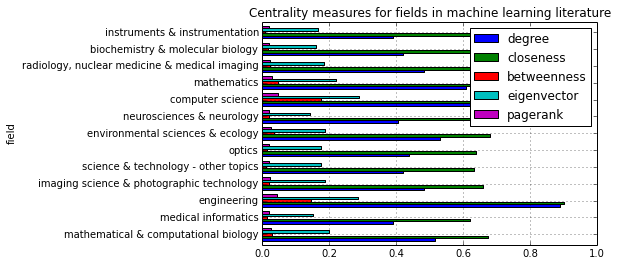

In [28]:


p = elite_group[['degree', 'closeness', 'betweenness', 'eigenvector', 'pagerank']].plot(kind='barh')

p = plt.title('Centrality measures for fields in machine learning literature')

Boundary spanners have low degree, high betweenness (bottlenecks or bridges) and high eigenvector centrality (actor connected to many actors who are connected). Here it looks mathematics and psychology could be playing something of these roles. Molecular biology and automation and control systems have spanning type positions too. 

## Authors in ML literature



In [6]:
df.af = df.AF.dropna().str.lower().str.strip()
df.af = df.af.str.split('; ')
af_all = [d for de in df.af for d in de if d is not np.nan]
af_set = set(af_all)
print "There %s authors listed and unique authors number %s" % (len(af_all), len(af_set))
af_counts = {de:af_all.count(de) for de in af_set}
af_counts_sorted = sorted(af_counts.iteritems(), key = operator.itemgetter(1), reverse=True)
af_counts_sorted[0:20]

There 98535 authors listed and unique authors number 62785


[('mueller, klaus-robert', 43),
 ('zhou, zhi-hua', 42),
 ('dzeroski, s', 41),
 ('nanni, loris', 38),
 ('bratko, i', 36),
 ('pedrycz, witold', 36),
 ('huellermeier, eyke', 33),
 ('king, rd', 33),
 ('lumini, alessandra', 32),
 ('santos, igor', 32),
 ('wang, wei', 30),
 ('wozniak, michal', 28),
 ('dzeroski, saso', 28),
 ('esposito, f', 26),
 ('hong, tp', 25),
 ('polat, kemal', 25),
 ('xu, hua', 25),
 ('kononenko, i', 25),
 ('sugiyama, masashi', 24),
 ('larranaga, pedro', 24)]

In [34]:
# these still need cleaning -- can see some duplicates
#To check out some of these

sq =gs.ScholarQuerier(author = 'Ross D King', count=50)
sq.query('')
print({a['title']:a['num_citations'] for a in sq.articles})
{a['title']:a['url'] for a in sq.articles}

{u'Theories for mutagenicity: A study in first-order and feature-based induction': 355, u'Application of metabolomics to plant genotype discrimination using statistics and machine learning': 231, u'Mutagenesis: ILP experiments in a non-determinate biological domain': 190, u'Relating chemical activity to structure: an examination of ILP successes': 130, u'Drug design by machine learning: The use of inductive logic programming to model the structure-activity relationships of trimethoprim analogues binding to  &hellip;': 269, u'Carcinogenesis predictions using ILP': 124, u'Identification and application of the concepts important for accurate and reliable protein secondary structure prediction': 424, u'Statlog: comparison of classification algorithms on large real-world problems': 183, u'Finding Frequent Substructures in Chemical Compounds.': 325, u'Identification and analysis of functional elements in 1% of the human genome by the ENCODE pilot project': 2605, u'Hierarchical metabolomics d

{u'Application of metabolomics to plant genotype discrimination using statistics and machine learning': u'http://bioinformatics.oxfordjournals.org/content/18/suppl_2/S241.short',
 u'Carcinogenesis predictions using ILP': u'http://link.springer.com/chapter/10.1007/3540635149_56',
 u'Cascaded multiple classifiers for secondary structure prediction': u'http://journals.cambridge.org/abstract_S0961836800993854',
 u'Drug design by machine learning: The use of inductive logic programming to model the structure-activity relationships of trimethoprim analogues binding to  &hellip;': u'http://www.pnas.org/content/89/23/11322.short',
 u'Finding Frequent Substructures in Chemical Compounds.': u'http://www.aaai.org/Papers/KDD/1998/KDD98-005',
 u'Functional genomic hypothesis generation and experimentation by a robot scientist': u'http://www.nature.com/nature/journal/v427/n6971/abs/nature02236.html',
 u'Hierarchical metabolomics demonstrates substantial compositional similarity between genetically m

There are some interesting differences here:

   -  Klaus Mueller works on medical decisions
   -  dzeroski works on induction
   -  zhou, zhi-hua at nanjing works on facial recognition
   - Ross King works on synthetic biology and proteins, and in particular, the automation of science using AI

## Who has been cited most in the machine learning literature?

Within the machine learning references, we can look just at the times cited field provided by Web of Science.  It seems that Breiman's RandomForests paper is the most important, followed by a wireless paper, then two papers in ecology, a methods paper, then the newer technique of Gaussian processes, followed by a text categorisation paper, then molecular biology paper, then three more methods papers, followed by some face detection articles and cancer-related papers. 

In [7]:
df[['AU', 'TI', 'TC', 'PY', 'ID', 'DE']][df.TC>500].sort('TC', ascending=False)

,AU,TI,TC,PY,ID,DE
17863,"Breiman, L",Random forests,4281,2001,NaN,classification; regression; ensemble
21848,"Haykin, S",Cognitive radio: Brain-empowered wireless comm...,2757,2005,NANOTUBE ELECTRONICS; SPECTRUM ESTIMATION,awareness; channel-state estimation and predic...
3652,"Elith, J; Graham, CH; Anderson, RP; Dudik, M; ...",Novel methods improve prediction of species' d...,1574,2006,CLIMATE-CHANGE; LOGISTIC-REGRESSION; DISTRIBUT...,NaN
3805,"Phillips, SJ; Anderson, RP; Schapire, RE",Maximum entropy modeling of species geographic...,1531,2006,OPERATING CHARACTERISTIC CURVES; GENERALIZED A...,maximum entropy; distribution; modeling; niche...
3591,"Fawcett, T",An introduction to ROC analysis,1488,2006,CLASSIFICATION; CURVE; AREA,ROC analysis; classifier evaluation; evaluatio...
18165,"Rasmussen, CE; Williams, CKI",Gaussian Processes for Machine Learning,1320,2005,SUPPORT VECTOR MACHINES; SPLINE FUNCTIONS; BAY...,NaN
22378,"Sebastiani, F",Machine learning in automated text categorization,1296,2002,PROBABILISTIC INFORMATION-RETRIEVAL; DOCUMENT ...,algorithms; experimentation; theory; machine l...
3692,"Krogan, NJ; Cagney, G; Yu, HY; Zhong, GQ; Guo,...",Global landscape of protein complexes in the y...,1257,2006,INTERACTION NETWORK; MASS-SPECTROMETRY; RNA-PO...,NaN
2846,"Kaelbling, LP; Littman, ML; Moore, AW",Reinforcement learning: A survey,1255,1996,ALGORITHMS,NaN
24611,"Friedman, J; Hastie, T; Tibshirani, R",Additive logistic regression: A statistical vi...,1248,2000,CLASSIFICATION,classification; tree; nonparametric estimation...


In [8]:
df.ix[df.TC.idxmax(), 51:]

SP                                                          NaN
SU                                                          NaN
TC                                                         4281
TI                                               Random forests
UT                                          WOS:000170489900001
VL                                                           45
WC                    Computer Science, Artificial Intelligence
Z9                                                         4457
﻿PT                                                           J
cited_refs    [amit y, 1997, neural comput, v9, p1545, doi 1...
topics                   [classification, regression, ensemble]
fields                                       [computer science]
Name: 17863, dtype: object

But this doesn't say who has been cited most  in the literature. There are around 350,000 unique references cited in these papers, amongst 650,000 total citations. 

In [9]:
all_refs = [ref for refs in df.cited_refs for ref in refs]
ref_collection = collections.Counter(all_refs)
ref_collection.most_common(n=20)

[('quinlan j. r., 1993, c4 5 programs machin', 1701),
 ('breiman l, 2001, mach learn, v45, p5, doi 10.1023/a:1010933404324', 1394),
 ('vapnik vn, 1998, stat learning theory', 1384),
 ('vapnik v. n, 1995, nature stat learning', 1344),
 ('mitchell t, 1997, machine learning', 1201),
 ('witten i. h., 2005, data mining practica', 1063),
 ('nan', 1033),
 ('cortes c, 1995, mach learn, v20, p273, doi 10.1023/a:1022627411411', 1009),
 ('breiman l, 1984, classification regre', 982),
 ('quinlan j. r., 1986, machine learning, v1, doi 10.1023/a:1022643204877',
  840),
 ('cristianini n., 2000, intro support vector', 801),
 ('breiman l, 1996, mach learn, v24, p123, doi 10.1007/bf00058655', 748),
 ('chang c.-c., 2001, libsvm lib support v', 678),
 ('duda r. o., 2001, pattern classificati', 636),
 ('burges cjc, 1998, data min knowl disc, v2, p121, doi 10.1023/a:1009715923555',
  616),
 ('bishop c.m., 1995, neural networks patt', 528),
 ('freund y, 1997, j comput syst sci, v55, p119, doi 10.1006/jcss.19

In [42]:

sq =gs.ScholarQuerier(author = 'Ross J Quinlan', count=50)
sq.query('')
print(ml.sorted_map({a['title']:a['num_citations'] for a in sq.articles}))
{a['title']:a['url'] for a in sq.articles}

[(u'C4. 5: programs for machine learning', 22286), (u'Induction of decision trees', 12413), (u'Learning logical definitions from relations', 1958), (u'Simplifying decision trees', 1442), (u'Learning efficient classification procedures and their application to chess end games', 1389), (u'Bagging, boosting, and C4. 5', 1330), (u'Improved use of continuous attributes in C4. 5', 1099), (u'Cited by 938', 938), (u'Top 10 algorithms in data mining', 831), (u'FOIL: A midterm report', 565), (u'Generating Production Rules from Decision Trees.', 457), (u'Combining Instance-Based and Model-Based Learning.', 377), (u'The effect of noise on concept learning', 363), (u'Unknown attribute values in induction.', 361), (u'Decision trees and decision-making', 319), (u'Cited by 303', 303), (u'Cited by 235', 235), (u'Inductive knowledge acquisition: a case study', 203), (u'Inferno: A cautious approach to uncertain inference', 195), (u'Induction of logic programs: FOIL and related systems', 194)]


{u'Bagging, boosting, and C4. 5': u'http://www.cs.ecu.edu/~dingq/CSCI6905/readings/BaggingBoosting.pdf',
 u'C4. 5: programs for machine learning': u'http://books.google.com/books?hl=en&lr=&id=HExncpjbYroC&oi=fnd&pg=PR7&dq=+Ross+J+Quinlan&ots=nKr8iTx_1j&sig=9s5BuDdObVNRu2hmmZUfbilN7U8',
 u'Cited by 235': u'http://scholar.google.com/scholar?cites=17708554099668242973&as_sdt=2005&sciodt=1,5&hl=en&num=20',
 u'Cited by 303': u'http://scholar.google.com/scholar?cites=14591131946535439496&as_sdt=2005&sciodt=1,5&hl=en&num=20',
 u'Cited by 938': u'http://scholar.google.com/scholar?cites=8617689792676967274&as_sdt=2005&sciodt=1,5&hl=en&num=20',
 u'Combining Instance-Based and Model-Based Learning.': u'http://cs.ecs.baylor.edu/~hamerly/courses/5325_11s/papers/ibl/quinlan1993combining.pdf',
 u'Decision trees and decision-making': u'http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=52545',
 u'FOIL: A midterm report': u'http://link.springer.com/chapter/10.1007/3-540-56602-3_124',
 u'Generating Pr

##  Co-authorship networks in ML

How tightly networked are the publications in terms of co-writing? This might need to be done over time. 

In [43]:
au_g = ml.wos_author_graph(df)

Adding nodes for authors ... 
Adding edges for co-authors... 
Author graph has 51697 authors and 215353 co-author connects


In [ ]:
pos, sel = gt.graph_draw(au_g)

KeyboardInterrupt: 

In [37]:
v_comm = gt.community_structure(au_g, 1000, 5)
gt.graph_draw(au_g, pos=pos, vertex_color = v_comm,output = '../figure/ml_author_net_2000.png')

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x16332210, at 0x14cbb8d0>

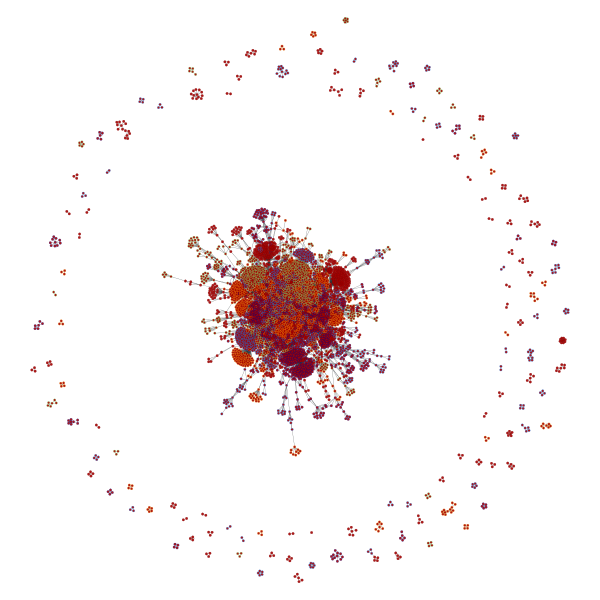

In [42]:
i =IPython.display.Image('../figure/ml_author_net_2000.png')
print('This is the author community network prior up to 2000')

## The techniques and topics in the literature

This relies on the 'DE' in the Web of Science records

In [11]:
# topics seem to be in the DE field


de_all = [d for de in df.topics.dropna() for d in de]

de_set = set(de_all)
print "All topics has %s and unique topics number %s" % (len(de_all), len(de_set))

All topics has 89645 and unique topics number 34407


In [12]:
de_counts = {de:de_all.count(de) for de in de_set}

The problem is that the topics mix techniques and application: principal component analysis stands alongside face recognition. So we need to sort those out first.
I've only considered a manual way to do this. 

In [13]:
# to see how topics are distributed

de_counts_sorted = sorted(de_counts.iteritems(), key = operator.itemgetter(1), reverse=True)
de_counts_sorted[0:50]

[('machine learning', 7607),
 ('support vector machine', 1792),
 ('classification', 1164),
 ('data mining', 974),
 ('neural network', 868),
 ('feature selection', 649),
 ('decision tree', 513),
 ('pattern recognition', 408),
 ('clustering', 322),
 ('artificial intelligence', 322),
 ('random forest', 260),
 ('genetic algorithms', 226),
 ('natural language processing', 226),
 ('bioinformatics', 219),
 ('reinforcement learning', 216),
 ('prediction', 214),
 ('feature extraction', 212),
 ('genetic algorithm', 202),
 ('neural networks', 176),
 ('boosting', 168),
 ('text mining', 163),
 ('semi-supervised learning', 158),
 ('algorithms', 158),
 ('information retrieval', 148),
 ('genetic programming', 147),
 ('knowledge discovery', 143),
 ('supervised learning', 141),
 ('regression', 140),
 ('optimization', 139),
 ('kernel methods', 139),
 ('knowledge acquisition', 137),
 ('computer vision', 136),
 ('bayesian networks', 135),
 ('image processing', 127),
 ('text classification', 127),
 ('suppor

The most frequent ones are techniques, but there are also lots of applications here - text classification, computer vision, intrusion detection, etc. To sort out the techniques, I classified by the hand the top 1000

In [14]:
techniques_domains = pickle.load(open('technique_classification.pyd', 'r'))

In [16]:
tech_s = sorted([tech for tech, cl in techniques_domains.iteritems() if cl == 'y'])

print(len(tech_s))
tech_cleaned = [re.sub('\(.+\)', '',t) for t in tech_s]

tech_cleaned[:30]
tech_cleaned.remove('artificial intelligence')
tech_cleaned.remove('machine learning')
tech_cleaned.remove('data mining')
tech_cleaned.remove('pattern recognition')

print('Number of different techniques in the literature: %d'%len(set(tech_cleaned)))
tech_cleaned[0:30]
#tech_cleaned.count('decision tree')

459
Number of different techniques in the literature: 454


['abductive networks',
 'abstraction',
 'active learning',
 'adaboost',
 'adaptive control',
 'adaptive learning',
 'adaptive systems',
 'algorithm selection',
 'approximation',
 'artificial immune systems',
 'artificial neural network',
 'artificial neural network ',
 'association rule',
 'association rule mining',
 'association rules',
 'associative classification',
 'auc',
 'automatic classification',
 'backpropagation',
 'bagging',
 'bayesian',
 'bayesian belief networks',
 'bayesian classifier',
 'bayesian classifiers',
 'bayesian inference',
 'bayesian methods',
 'bayesian network',
 'bias',
 'binary classification',
 'blind signal separation']

### Domains

If techniques are removed, we are left with domains

In [17]:
domains = sorted([tech for tech, cl in techniques_domains.iteritems() if cl == 'n'])
domains[:40]

['accelerometer',
 'accelerometers',
 'accuracy',
 'activity recognition',
 'adaptation',
 'adaptive',
 'adaptive resonance theory',
 'adaptive signal processing',
 'adme',
 'admet',
 'affective computing',
 'agent',
 'agents',
 'aging',
 'airs',
 'algorithm',
 'alignment',
 "alzheimer's disease",
 'ambient intelligence',
 'amino acid composition',
 'analogy',
 'anfis',
 'ann',
 'annotation',
 'anomaly detection',
 'ant colony optimization',
 'applications',
 'architecture',
 'artificial immune system',
 'artmap',
 'attribute reduction',
 'attribute selection',
 'automatic image annotation',
 'automation',
 'autonomous agents',
 'autonomous navigation',
 'bankruptcy prediction',
 'bci',
 'benchmark',
 'bioinformatic']

# A network of techniques

The idea here is to see how techniques are connected to each other. There are roughly 500 techniques across 23000 references. Some of these references have multiple techniques. Not all techniques are techniques. Some name problems. So as well as removing domains, we need to remove problems. 

In [20]:
# classify references by techniques
tech_gr = nx.DiGraph()

#construct technique edge list 

# find techniques in a reference and add co-present techniques
# as edges to graph

tech_cleaned.append('nn classifier')
for topics in df.topics.dropna():
    techs = [t for t in topics if tech_cleaned.count(t) > 0]
    edges = [c for c in itertools.combinations(techs,2)]
    for subject_id, object_id in edges:
        if tech_gr.has_edge(subject_id, object_id):
            tech_gr[subject_id][object_id]['weight'] += 1
        else:
            tech_gr.add_edge(subject_id, object_id, weight=1)

tech_gr.size()    


4635

In [23]:
tech_core = trim_degrees(tech_gr,13 )
tech_core= trim_edges(tech_core, 10)
print tech_core.size()

nx.draw_spring(tech_core, k=0.4,width = 0.2,alph=0.5, figsize=(10,10))


NameError: name 'trim_degrees' is not defined

In [10]:
tech_degree_c = nx.degree_centrality(tech_core)
tech_degree_cs = ml.sorted_map(tech_degree_c)
tech_degree_cs[:10]

[('classification', 0.7333333333333333),
 ('support vector machine', 0.7333333333333333),
 ('neural network', 0.3333333333333333),
 ('decision tree', 0.2),
 ('feature selection', 0.2),
 ('genetic algorithm', 0.2),
 ('boosting', 0.13333333333333333),
 ('feature extraction', 0.13333333333333333),
 ('prediction', 0.13333333333333333),
 ('regression', 0.13333333333333333)]

In [14]:
tech_closeness_c = nx.closeness_centrality(tech_core)
tech_closeness_cs = sorted_map(tech_closeness_c)
tech_closeness_cs[:10]

[('classification', 0.75),
 ('support vector machine', 0.6521739130434783),
 ('feature selection', 0.5357142857142857),
 ('decision tree', 0.5172413793103449),
 ('prediction', 0.5172413793103449),
 ('boosting', 0.46875),
 ('clustering', 0.4411764705882353),
 ('feature extraction', 0.4411764705882353),
 ('genetic programming', 0.4411764705882353),
 ('optimization', 0.4411764705882353)]

In [15]:
tech_between_c = nx.betweenness_centrality(tech_core)
tech_between_cs = sorted_map(tech_between_c)
tech_between_cs[:10]

[('classification', 0.7380952380952381),
 ('support vector machine', 0.4285714285714286),
 ('boosting', 0.13333333333333336),
 ('feature selection', 0.0380952380952381),
 ('genetic algorithm', 0.004761904761904762),
 ('bagging', 0.0),
 ('clustering', 0.0),
 ('decision tree', 0.0),
 ('feature extraction', 0.0),
 ('genetic programming', 0.0)]

In [16]:
tech_eigen_c = nx.eigenvector_centrality(tech_core)
tech_eigen_cs = sorted_map(tech_eigen_c)
tech_eigen_cs[:10]

[('classification', 0.5420751035645175),
 ('support vector machine', 0.5254496358830248),
 ('feature selection', 0.38572455726503596),
 ('neural network', 0.269881214078494),
 ('decision tree', 0.23417140871318876),
 ('genetic algorithm', 0.21563519951155427),
 ('prediction', 0.164089678158054),
 ('regression', 0.1541950134766508),
 ('clustering', 0.12849584456387564),
 ('feature extraction', 0.08994709119471296)]

In [17]:
tech_pr = nx.pagerank(tech_core)
tech_pr_s = sorted_map(tech_pr)

In [18]:
n1 = {x[0] for x in tech_degree_cs[:10]}
n2 = {x[0] for x in tech_closeness_cs[:10]}
n3 = {x[0] for x in tech_between_cs[:10]}
n4 = {x[0] for x in tech_eigen_cs[:10]}
n5 = {x[0] for x in tech_pr_s[:10]}
names = n1 | n2 | n3 | n4 | n5
table =[[name, tech_degree_c[name], tech_closeness_c[name], tech_between_c[name], tech_eigen_c[name], tech_pr[name]] for name in names]
tech_group = pd.DataFrame(data = table, columns = ['technique','degree', 'closeness', 'betweenness', 'eigenvector', 'pagerank'])
tech_group = tech_group.set_index('technique')
tech_group

,degree,closeness,betweenness,eigenvector,pagerank
technique,,,,,
genetic programming,0.066667,0.441176,0.000000,0.083522,0.023787
classification,0.666667,0.750000,0.738095,0.542075,0.246499
decision tree,0.133333,0.517241,0.000000,0.234171,0.048946
feature extraction,0.066667,0.441176,0.000000,0.089947,0.024895
prediction,0.133333,0.517241,0.000000,0.164090,0.036992
boosting,0.133333,0.468750,0.133333,0.080360,0.053163
regression,0.066667,0.441176,0.000000,0.154195,0.035981
clustering,0.066667,0.441176,0.000000,0.128496,0.031547
support vector machine,0.533333,0.652174,0.428571,0.525450,0.189913


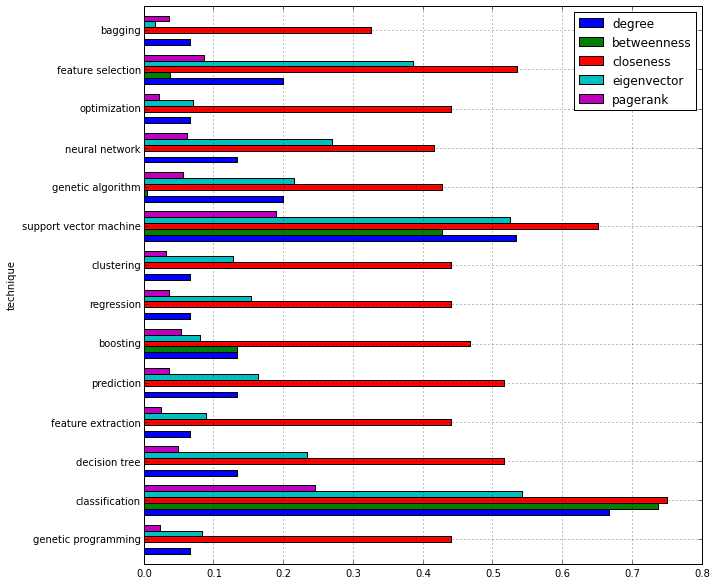

In [19]:
tech_group[['degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank']].plot(kind='barh',figsize=(10,10))

The highest degree centralities are machine learning, classification, support vector machine and data-mining. There is a bit of mixture here - machine learning or data mining are whole areas of technique, whereas support bector machine or neural network are particular techniques. If these were taken out, the network starts to look at bit different. Also some techniques are almost synonous -- feature selection and feature extraction are almost the same thing. If they were added together, their closeness centrality would be greater than many of the others. 

It is really striking how important support vector machines, as well as neural networks and decision trees. They figure heavily.

Classification is really important -- it is second to machine learning on most measures of centrality. 

In terms of boundary spanning, it seems that feature extraction, feature selection suddenly figure more in the eigenvector measure -- does that mean that they are linking different subgraphs more?

 

## Cliques and clusters in the techniques



In [20]:
print(len(tech_gr))
len(nx.connected_component_subgraphs(tech_gr.to_undirected()))

422


1

As it looks from above, this is one hairball of a graph of techniques

In [21]:
svm = nx.ego_graph(tech_gr.to_undirected(), 'support vector machine', radius=2)
nx.average_clustering(svm)

0.3530765745019574

In [22]:
neural = nx.ego_graph(tech_gr.to_undirected(), 'neural network', radius=2)
print(len(neural))
nx.average_clustering(neural)


416


0.3541360296708294

### Trim the edges based on weights

In [21]:
def trim_edges(g, weight=1):
    g2 = nx.Graph()
    [g2.add_edge(f,to, edata) for f, to, edata in g.edges(data=True) if edata['weight']>weight]
    return g2

def island_method(g, iterations=5):
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]
    mn = int(min(weights))
    mx = int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [24]:
islands = island_method(tech_gr)
len(islands)
for i in islands:
    print i[0], len(i[1]), len(nx.connected_component_subgraphs(i[1]))

1 321 6
9 18 2
17 8 1
25 4 1
33 4 1
41 2 1


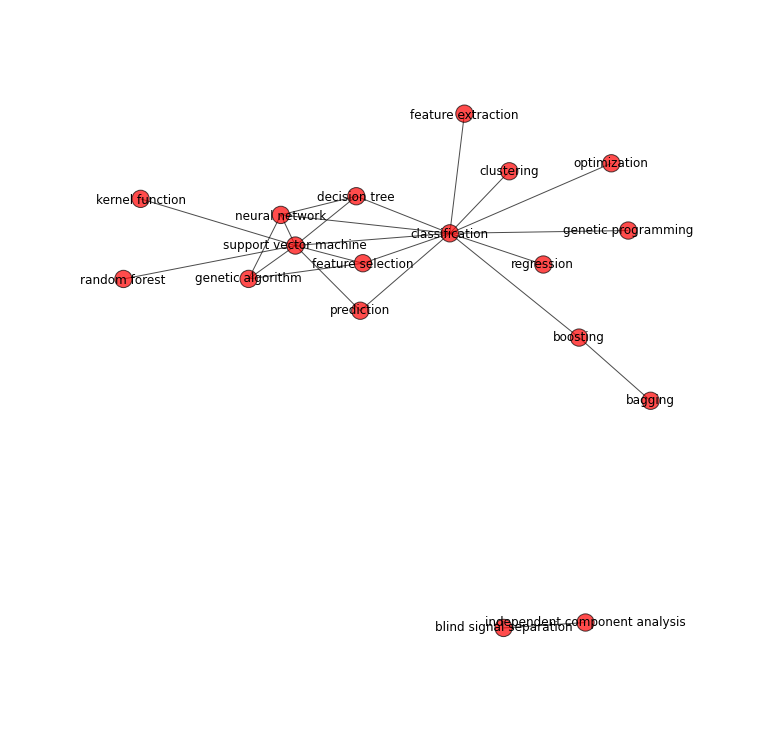

In [61]:
l = nx.fruchterman_reingold_layout(islands[1][1], k=0.4)
nx.draw_spring(islands[1][1], layout = l, alpha=0.7)

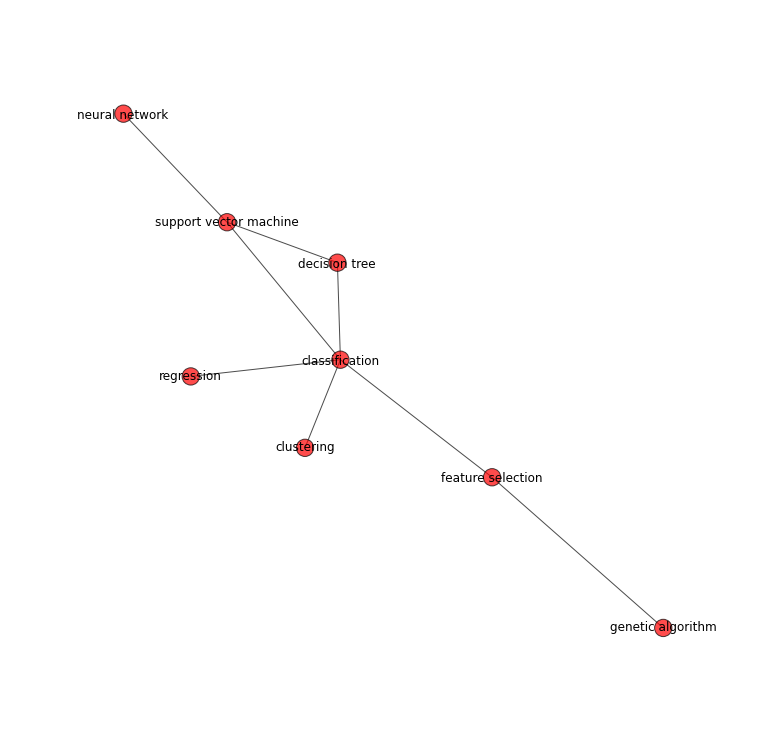

In [66]:
nx.draw_spring(islands[2][1], k=0.3,alpha=0.7)

This is produced used the island method of splitting giant components in to smaller areas of stronger relationality. In this case, there are only two connected subgraphs, so it is not possible to raise the water level much. 

No real surprises here, but it is interesting that pattern recognition survives alongside classification and feature selection. As usual, the only 2 techniques are neural network and support vector machine. It would be interesting perhaps to see what happens if take the fields such as data mining and artificial intelligence out. 

In [309]:
len(nx.connected_component_subgraphs(tech_gr.to_undirected()))

1

In [27]:
tech_trimmed = trim_edges(tech_gr,1)
len(tech_trimmed)
gs=nx.connected_component_subgraphs(tech_trimmed)
gs[0].size()
tech_gr.size()
sorted(tech_gr.edges(data=True))

[('abductive networks', 'feature ranking', {'weight': 1}),
 ('abductive networks', 'feature selection', {'weight': 1}),
 ('abductive networks', 'learning systems', {'weight': 1}),
 ('abductive networks', 'mutual information', {'weight': 1}),
 ('abductive networks', 'prediction', {'weight': 2}),
 ('abductive networks', 'spectral analysis', {'weight': 2}),
 ('abstraction', 'classification', {'weight': 1}),
 ('abstraction', 'feature selection', {'weight': 1}),
 ('abstraction', 'generalization', {'weight': 1}),
 ('abstraction', 'inference', {'weight': 1}),
 ('abstraction', 'multistrategy learning', {'weight': 1}),
 ('abstraction', 'online learning', {'weight': 1}),
 ('abstraction', 'optimization', {'weight': 1}),
 ('abstraction', 'pattern matching', {'weight': 1}),
 ('active learning', 'adaboost', {'weight': 1}),
 ('active learning', 'bootstrapping', {'weight': 1}),
 ('active learning', 'classification', {'weight': 5}),
 ('active learning', 'ensemble learning', {'weight': 1}),
 ('active le

In [58]:
classi =nx.ego_graph(tech_trimmed, 'logistic regression')
classi.size()


71

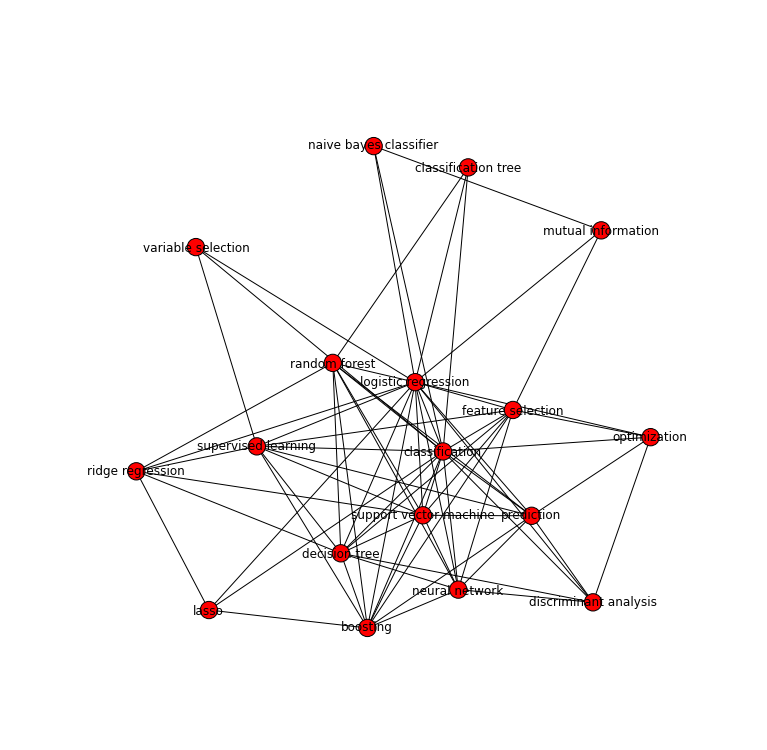

In [57]:
layout = nx.fruchterman_reingold_layout(classi, k=0.5, weight= 'weight')
nx.draw(classi, layout, figsize(10,10))

# Linking fields and topics

Can we link topics to fields?

## Idea A: use networks

1. clean up fields so each publication has the most distinctive fields - remove 'computer science'
2. clean up topics so that each publication has the most distinctive topics -- remove 'machine learning'
3. create bipartite network of fields & topics?

## Idea B: use association/correlations

In [12]:
# to create distinctive topics, drop machine learning
ftdf = df[['fields', 'topics']]
print(ftdf.shape)
ftdf.head()

(23240, 2)


,fields,topics
0,"[computer science, engineering]","[spam detection, machine learning, web securit..."
1,[computer science],NaN
2,[computer science],"[machine learning, c4.5desicion tree, encoded ..."
3,"[computer science, engineering]","[brain mri images, nn classifier, decision tree]"
4,"[engineering, telecommunications]","[acoustic emission, creep material rupture, ne..."


In [13]:
gr = nx.Graph()

#[i for i in itertools.combinations(de, 2) for de in df.topics[:100]]
gr.add_edges_from([i for de in df.topics.dropna()[0:200] for i in itertools.combinations(de,2)])

In [14]:
gr2 = nx.Graph()
[gr2.add_edge(f[0],t[0]) for f,t in zip(ftdf.fields, ftdf.topics) if f is not NaN and t is not NaN]
gr2.size()

8958

In [15]:
print('topics network has %s edges and %s nodes'%(gr.number_of_edges(), gr.number_of_nodes()))
nx.average_degree_connectivity(gr)
#nx.draw_networkx(gr)

topics network has 1839 edges and 694 nodes


{1: 65.11111111111111,
 2: 35.6144578313253,
 3: 36.29323308270677,
 4: 32.34905660377358,
 5: 27.657471264367818,
 6: 34.2328431372549,
 7: 31.665024630541872,
 8: 17.85576923076923,
 9: 33.01851851851852,
 10: 17.833333333333332,
 11: 21.836363636363636,
 12: 24.805555555555557,
 13: 18.615384615384617,
 14: 14.723214285714286,
 15: 29.866666666666667,
 16: 28.75,
 17: 14.676470588235293,
 24: 19.25,
 25: 8.08,
 27: 17.25925925925926,
 34: 13.911764705882353,
 43: 13.0,
 68: 10.514705882352942,
 264: 5.617424242424242}

In [16]:
gr.remove_node('machine learning')

In [17]:
deg=nx.degree(gr)

In [18]:
deg['support vector machine']
deg_sorted = sorted(deg.iteritems(), key=lambda(k,v):(-v,k))
deg_sorted[:50]

[('support vector machine', 67),
 ('classification', 42),
 ('data mining', 33),
 ('feature selection', 26),
 ('neural network', 26),
 ('clustering', 25),
 ('feature extraction', 23),
 ('decision tree', 17),
 ('boosting', 16),
 ('pattern recognition', 15),
 ('algorithms', 14),
 ('centroid-list', 14),
 ('dbscan technique', 14),
 ('ddbj', 14),
 ('discernibility relation', 14),
 ('distinction table', 14),
 ('embl', 14),
 ('feature-list', 14),
 ('format binding', 14),
 ('genbank', 14),
 ('match algorithm', 14),
 ('metroplis algorithm', 14),
 ('multi objective ga', 14),
 ('nsga ii', 14),
 ('reduct', 14),
 ('search & retrieve algorithm', 14),
 ('computer vision', 13),
 ('semi-supervised learning', 13),
 ('pca', 12),
 ('prediction', 12),
 ('adaboost', 11),
 ('classifiers', 11),
 ('rough set', 11),
 ('youtube', 11),
 ('experimentation', 10),
 ('learning', 10),
 ('naive bayes classifier', 10),
 ('sentiment analysis', 10),
 ('tracking', 10),
 ('information retrieval', 9),
 ('intrusion detection',

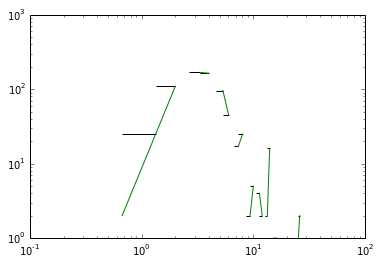

In [19]:
h=hist(deg.values(), 100)
loglog(h[1][1:], h[0])

In [20]:
#remove 1-degree nodes

g2 = gr.copy()
d = nx.degree(g2)
remove = 10
[g2.remove_node(n) for n in g2.nodes() if d[n] <= remove]
print g2.size()

nsizes = [n*10 for n in d.values() if n >remove]

130


/usr/local/lib/python2.7/dist-packages/pygraphviz/agraph.py:1281: RuntimeWarning: Fontconfig warning: "/etc/fonts/conf.d/50-user.conf", line 9: reading configurations from ~/.fonts.conf is deprecated.

  warnings.warn("".join(errors),RuntimeWarning)


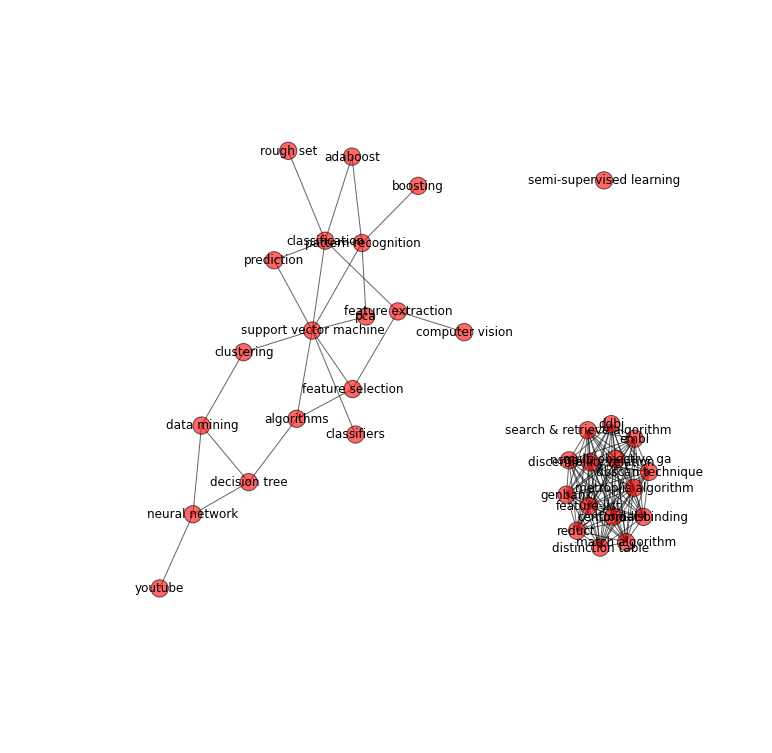

In [23]:
f = plt.figure(figsize=(10,10))

nx.draw_graphviz(g2, alpha=0.6, k=0.6,node_sizes = nsizes)


# 2 mode networks: disciplines and techniques

In [24]:
from networkx.algorithms import bipartite as bi

In [25]:
tx = ml.discipline_techniques_graph(df)

In [26]:
tx.size()
disciplines = df.SC_l.unique()
techniques = {det  for de in df.topics if de is not nan for det in de}

In [27]:
df.SC_l

0                         computer science; engineering
1                                      computer science
2                                      computer science
3                         computer science; engineering
4                       engineering; telecommunications
5     automation & control systems; computer science...
6     automation & control systems; computer science...
7     automation & control systems; computer science...
8                         computer science; engineering
9                      biophysics; engineering; physics
10                     biophysics; engineering; physics
11                     biophysics; engineering; physics
12          business & economics; public administration
13          business & economics; public administration
14                                     computer science
...
23225                                     computer science
23226                 computer science; telecommunications
23227                                 

In [28]:
len(techniques)

28477

In [29]:
disc = bi.projected_graph(tx, g2.nodes())

In [31]:
sorted(disc.degree().iteritems(), key= operator.itemgetter(1))

[('discernibility relation', 1),
 ('genbank', 1),
 ('embl', 1),
 ('centroid-list', 1),
 ('medical laboratory technology; pathology', 1),
 ('format binding', 1),
 ('reduct', 1),
 ('match algorithm', 1),
 ('ddbj', 1),
 ('feature-list', 1),
 ('nsga ii', 1),
 ('metroplis algorithm', 1),
 ('multi objective ga', 1),
 ('physical geography', 1),
 ('pharmacology & pharmacy', 1),
 ('dbscan technique', 1),
 ('search & retrieve algorithm', 1),
 ('distinction table', 1),
 ('youtube', 1),
 ('biochemistry & molecular biology', 1),
 ('computer science; medical informatics; nursing', 2),
 ('engineering; instruments & instrumentation; optics', 2),
 ('materials science', 2),
 ('engineering; radiology, nuclear medicine & medical imaging', 2),
 ('engineering; nuclear science & technology', 2),
 ('instruments & instrumentation; spectroscopy', 2),
 ('agriculture; computer science', 2),
 ('biochemistry & molecular biology; optics; radiology, nuclear medicine & medical imaging',
  2),
 ('cell biology', 2),
 ('

## Retrieving further literature if needed from WoS

In [60]:
## generate searches that can be run back against WoS - it says it will take up to 5000 terms!

'"'+'" or "'.join([de for de,val in de_counts_sorted if val > 90 and val < 200]) + '"'

'"bioinformatics" or "reinforcement learning" or "genetic algorithm" or "feature extraction" or "decision tree" or "prediction" or "natural language processing" or "boosting" or "artificial neural networks" or "knowledge discovery" or "knowledge acquisition" or "text mining" or "kernel methods" or "genetic programming" or "information retrieval" or "algorithms" or "semi-supervised learning" or "optimization" or "supervised learning" or "regression" or "pattern classification" or "bayesian networks" or "information extraction" or "text classification" or "image processing" or "artificial neural network" or "random forest" or "intrusion detection" or "learning" or "fuzzy logic" or "rough sets" or "dimensionality reduction" or "computer vision" or "support vector regression" or "rough set" or "inductive logic programming"'

## Building a topic model


In [3]:
# <markdowncell>

# # The corpus of ML

# <codecell>

ti_ab = df.TI + df.AB
mlt = nltk.TextCollection([nltk.tokenize.word_tokenize(t) for t in ti_ab.dropna()])

# <markdowncell>
mlt.tokens[0:20]

['Detecting',
 'Spam',
 'in',
 'Chinese',
 'Microblogs',
 '-',
 'A',
 'study',
 'on',
 'Sina',
 'WeiboSina',
 'Weibo',
 'is',
 'the',
 'most',
 'popular',
 'and',
 'fast',
 'growing',
 'microblogging',
 'social',
 'network',
 'in',
 'China.',
 'However',
 ',',
 'more',
 'and',
 'more',
 'spam',
 'messages',
 'are',
 'also',
 'emerging',
 'on',
 'Sina',
 'Weibo.',
 'How',
 'to',
 'detect',
 'these',
 'spam',
 'is',
 'essential',
 'for',
 'the',
 'social',
 'network',
 'security.',
 'While',
 'most',
 'previous',
 'studies',
 'attempt',
 'to',
 'detect',
 'the',
 'microblogging',
 'spam',
 'by',
 'identifying',
 'spammers',
 ',',
 'in',
 'this',
 'paper',
 ',',
 'we',
 'want',
 'to',
 'exam',
 'whether',
 'we',
 'can',
 'detect',
 'the',
 'spam',
 'by',
 'each',
 'single',
 'Weibo',
 'message',
 ',',
 'because',
 'we',
 'notice',
 'that',
 'more',
 'and',
 'more',
 'spam',
 'Weibos',
 'are',
 'posted',
 'by',
 'normal',
 'users',
 'or',
 'even',
 'popular']

## The cited references

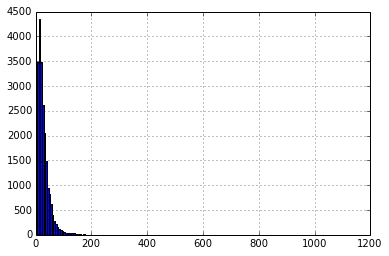

In [34]:
df.NR.hist(bins=200)

# Keywords of interest

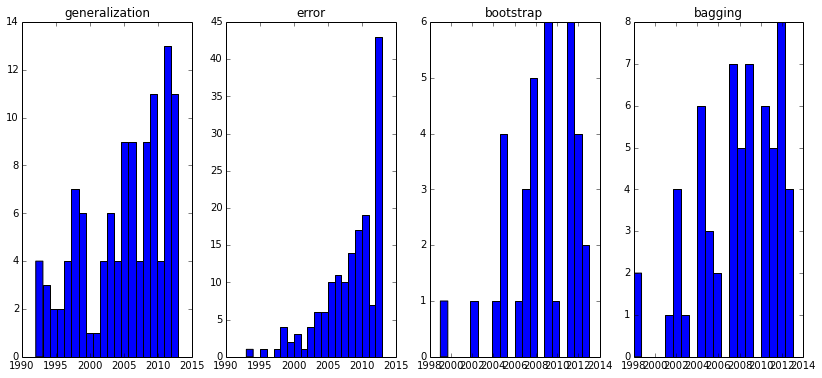

In [17]:
plt.figure(figsize=(14,6))

key1 = 'generalization'
k1 = ml.keyword_years(df, key1)
plt.subplot(141)
plt.hist(k1.PY, bins=20)
plt.title(key1)

key2 = 'error'
k2 = ml.keyword_years(df, key2)
plt.subplot(142)
plt.hist(k2.PY, bins=20)
plt.title(key2)

key3 = 'bootstrap'
k3 = ml.keyword_years(df, key3)
plt.subplot(143)
plt.hist(k3.PY, bins=20)
plt.title(key3)

key4 = 'bagging'
k4 = ml.keyword_years(df, key4)
plt.subplot(144)
plt.hist(k4.PY, bins=20)
plt.title(key4)
